In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error
import sklearn

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [3]:
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


In [4]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
        stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [5]:
# 전체 오차율
def error_ratio(pred, true):
    return np.mean(np.abs(pred-true)/true)

In [6]:
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath,news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋

In [7]:
stock_df['PINS'][:3]

0    24.99
1    24.99
2    24.99
Name: PINS, dtype: float64

In [8]:
### Set index as Date
stock_df = stock_df.set_index('Date')
total_df = total_df.set_index('Date')

In [9]:
test_filepath = '../../data/test.csv'
# test_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/test.csv'
y_test = pd.read_csv(test_filepath,index_col=0)
y_test.head(2)

,Close Price
Date,
2024-01-02,468.50
2024-01-03,470.26


# Preprocessing
- StandardScaling
- Make as Sequence Data

In [10]:
SEQUENCE_SIZE = 120
BATCH_SIZE = 64
OUTPUT_SIZE = 20
HIDDEN_SIZE = 128

def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, ]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, 1]  # Adjusted for Pandas
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

x_total, y_total = split_xy(total_df,SEQUENCE_SIZE,OUTPUT_SIZE)

x_stock, y_stock = split_xy(stock_df, SEQUENCE_SIZE,OUTPUT_SIZE)

In [11]:
print(x_total.shape, y_total.shape, x_stock.shape, y_stock.shape)
### Set Test data
x_test_total = np.reshape(total_df.iloc[-SEQUENCE_SIZE:].values,(1,SEQUENCE_SIZE,-1))
x_test_stock = np.reshape(stock_df.iloc[-SEQUENCE_SIZE:].values,(1,SEQUENCE_SIZE,-1))
print(x_test_total.shape, x_test_stock.shape)

(1118, 120, 58) (1118, 20) (1118, 120, 37) (1118, 20)
(1, 120, 58) (1, 120, 37)


In [12]:
### Scaling
# reshape to 2d and scaling
ss = StandardScaler()
x_total_scaled = ss.fit_transform(np.reshape(x_total,(
        x_total.shape[0],x_total.shape[1]*x_total.shape[2]
    )))
x_test_total = ss.transform(np.reshape(x_test_total,(
        x_test_total.shape[0],x_test_total.shape[1]*x_test_total.shape[2]
    )))
x_stock_scaled = ss.fit_transform(np.reshape(x_stock,(
        x_stock.shape[0],x_stock.shape[1]*x_stock.shape[2]
    )))
x_test_stock = ss.transform(np.reshape(x_test_stock,(
        x_test_stock.shape[0],x_test_stock.shape[1]*x_test_stock.shape[2]
    )))

### Train, Validation Split
tv_ratio = int(x_total_scaled.shape[0]*0.2) 
x_train_total = x_total_scaled[:-tv_ratio]
x_val_total = x_total_scaled[-tv_ratio:]
y_train_total = y_total[:-tv_ratio]
y_val_total = y_total[-tv_ratio:]

tv_ratio = int(x_stock_scaled.shape[0]*0.2) 
x_train_stock = x_stock_scaled[:-tv_ratio]
x_val_stock = x_stock_scaled[-tv_ratio:]
y_train_stock = y_stock[:-tv_ratio]
y_val_stock = y_stock[-tv_ratio:]

### reshape to 3d
x_train_total = np.reshape(x_train_total,(-1,SEQUENCE_SIZE,x_total.shape[2]))
x_val_total = np.reshape(x_val_total,(-1,SEQUENCE_SIZE,x_total.shape[2]))
x_test_total = np.reshape(x_test_total,(1,SEQUENCE_SIZE,-1))

x_train_stock = np.reshape(x_train_stock,(-1,SEQUENCE_SIZE,x_stock.shape[2]))
x_val_stock = np.reshape(x_val_stock,(-1,SEQUENCE_SIZE,x_stock.shape[2]))
x_test_stock = np.reshape(x_test_stock,(1,SEQUENCE_SIZE,-1))

In [13]:
print(x_train_total.shape, x_val_total.shape, x_test_total.shape)
print(y_train_total.shape, y_val_total.shape)
print(x_train_stock.shape, x_val_stock.shape, x_test_stock.shape)
print(y_train_stock.shape, y_val_stock.shape)
### x_total.shape[0] = x_train_total.shape[0]+x_val_total.shape[0]
print(x_total.shape[0],x_train_total.shape[0]+x_val_total.shape[0])

(895, 120, 58) (223, 120, 58) (1, 120, 58)
(895, 20) (223, 20)
(895, 120, 37) (223, 120, 37) (1, 120, 37)
(895, 20) (223, 20)
1118 1118


In [14]:
### to DataLoader
train_loader_total = DataLoader(
        TensorDataset(torch.tensor(x_train_total,dtype=torch.float32),
                      torch.tensor(y_train_total,dtype=torch.float32)),
        batch_size=BATCH_SIZE, shuffle=True)
val_loader_total = DataLoader(
        TensorDataset(torch.tensor(x_val_total,dtype=torch.float32),
                      torch.tensor(y_val_total,dtype=torch.float32)),
        batch_size=BATCH_SIZE, shuffle=False
    )

train_loader_stock = DataLoader(
        TensorDataset(torch.tensor(x_train_stock,dtype=torch.float32),
                      torch.tensor(y_train_stock,dtype=torch.float32)),
        batch_size=BATCH_SIZE, shuffle=True)
val_loader_stock = DataLoader(
        TensorDataset(torch.tensor(x_val_stock,dtype=torch.float32),
                      torch.tensor(y_val_stock,dtype=torch.float32)),
        batch_size=BATCH_SIZE, shuffle=False
    )

### test data to Tensor
x_test_total = torch.tensor(x_test_total,dtype=torch.float32)
x_test_stock = torch.tensor(x_test_stock,dtype=torch.float32)

# Positional encoding

In [15]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=120):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Constructing the Transformer Model

The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

* **input_dim**: The dimension of the input data, in this case we use only one input, the number of sunspots. ( input size = 1)
* **d_model**: The number of features(hidden states) in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
* **nhead**: The number of attention heads in the multi-head self-attention mechanism.
* **num_layers**: The number of transformer encoder layers.
* **dropout**: The dropout probability.



In [16]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead=4, num_layers=2, dropout=0.2, output_size=10,max_len=120):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Linear(input_dim, d_model,bias=True)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead,bias=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_size,bias=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
model_total = TransformerModel(input_dim=x_train_total.shape[2],
                               max_len=SEQUENCE_SIZE,
                               d_model=HIDDEN_SIZE,
                               output_size=OUTPUT_SIZE).to(device)
model_stock = TransformerModel(input_dim=x_train_stock.shape[2],
                               max_len=SEQUENCE_SIZE,
                               d_model=HIDDEN_SIZE,
                               output_size=OUTPUT_SIZE).to(device)

In [17]:
# Model Compile
criterion_total = RMSELoss()
# criterion_total = nn.MSELoss()
optimizer_total = torch.optim.Adam(model_total.parameters(), lr=0.001)
scheduler_total = ReduceLROnPlateau(optimizer_total, 'min', factor=0.3, patience=10, verbose=True)

criterion_stock = RMSELoss()
# criterion_stock = nn.MSELoss()
optimizer_stock = torch.optim.Adam(model_stock.parameters(), lr=0.001)
scheduler_stock = ReduceLROnPlateau(optimizer_stock, 'min', factor=0.3, patience=10, verbose=True)

In [18]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

# Total dataset Training

In [19]:
epochs = 1000
epoch_counter = 0
min_val_loss = float('inf')
done = False
patience = 50
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<epochs:
    epoch_counter+=1
    
    ### Training
    model_total.train()
    train_losses = []
    for batch in train_loader_total:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_stock.zero_grad()
        outputs = model_total(x_batch)
        loss = criterion_total(outputs, y_batch)
        loss.backward()
        optimizer_total.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)
    
    # Validation
    model_total.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader_total:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model_total(x_batch)
            loss = criterion_total(outputs, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler_total.step(val_loss)

    if es(model_total, val_loss):
        done = True

    # print loss every 5 epochs
    if epoch_counter%5 == 0 :
        print(f"Epoch {epoch_counter}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 5/1000, Train Loss: 419.9141, Validation Loss: 386.5430
Epoch 10/1000, Train Loss: 399.1331, Validation Loss: 362.8634
Epoch 15/1000, Train Loss: 370.1267, Validation Loss: 329.6369
Epoch 20/1000, Train Loss: 332.7107, Validation Loss: 287.0271
Epoch 25/1000, Train Loss: 287.5720, Validation Loss: 235.0231
Epoch 30/1000, Train Loss: 237.2585, Validation Loss: 174.4768
Epoch 35/1000, Train Loss: 185.6703, Validation Loss: 107.3365
Epoch 40/1000, Train Loss: 144.1984, Validation Loss: 57.4476
Epoch 45/1000, Train Loss: 132.6326, Validation Loss: 65.7818
Epoch 50/1000, Train Loss: 158.3495, Validation Loss: 127.2461
Epoch 00053: reducing learning rate of group 0 to 3.0000e-04.
Epoch 55/1000, Train Loss: 185.8297, Validation Loss: 164.5692
Epoch 60/1000, Train Loss: 190.6170, Validation Loss: 170.5904
Epoch 00064: reducing learning rate of group 0 to 9.0000e-05.
Epoch 65/1000, Train Loss: 190.6232, Validation Loss: 169.6623
Epoch 70/1000, Train Loss: 189.1924, Validation Loss: 167.18

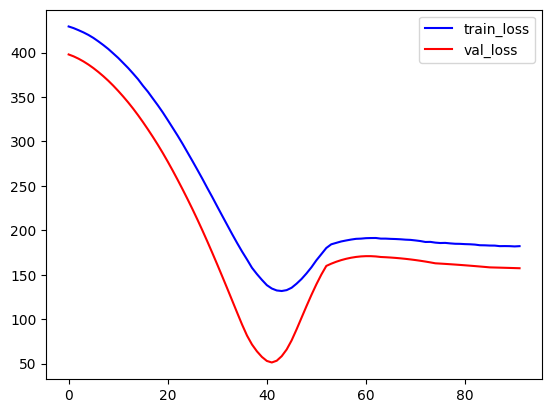

In [20]:
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

# Total dataset Evaluation and Plot results + Save results

In [21]:
# evaluation
model_total.eval()
with torch.no_grad():
    pred_total = model_total(x_test_total.to(device))
pred_total = pred_total.to('cpu').detach().numpy()
pred_total_reshape = np.reshape(pred_total,(-1,1))
print(pred_total_reshape.shape)

(20, 1)


In [22]:
y_test_SEQ = y_test[:OUTPUT_SIZE]

In [23]:
### Evaluate with error_ratio
print('Error Ratio :',error_ratio(pred_total_reshape, y_test_SEQ))

### R-squared, p-value
# r_squared는 1에 가까울수록 모델이 좋은 것
# p_value는 0.05 보다 작으면 유의미한 것
# 두가지를 만족하지 못한 것은 과적합된 것
r_squared = sm.OLS(y_test_SEQ,sm.add_constant(pred_total_reshape)).fit().rsquared
p_value = sm.OLS(y_test_SEQ,sm.add_constant(pred_total_reshape)).fit().f_pvalue
print("R-squared:", r_squared)
print("p-value:", p_value)

Error Ratio : 0.1904894305242583
R-squared: 0.0017335670520368662
p-value: 0.8616392672909964


In [24]:
### Save result
path = f'../../data/results/transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_total.csv'

result_total = pd.DataFrame(data={'true':np.reshape(y_test_SEQ,(-1)),
              'pred':np.reshape(pred_total_reshape,(-1)),
              'error_ratio':((pred_total_reshape-y_test_SEQ)/y_test_SEQ).iloc[:,0].values},
              index=y_test_SEQ.index)

result_total.to_csv(path)

# result_total = pd.read_csv(path,index_col=0) # set date column as index when reading the data

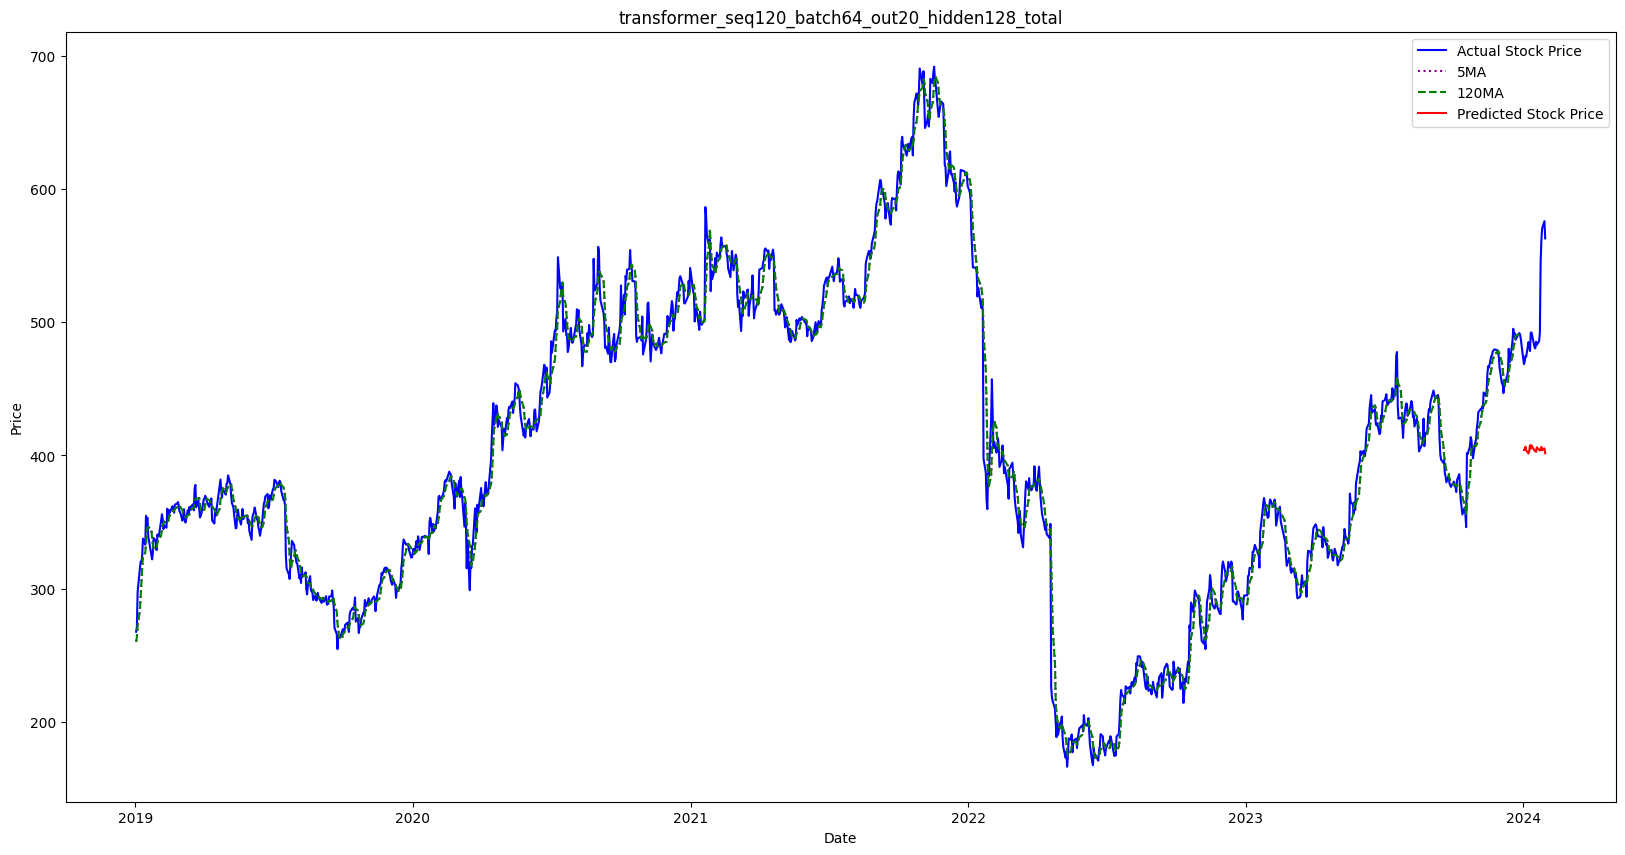

In [25]:
### Plot Result
actual_stock_price = stock_df[['Close','5MA','120MA']].reset_index().rename(columns={'Close':'true'})
actual_stock_price[['pred','error_ratio']] = 0
combined_df = pd.concat([actual_stock_price,
                        result_total.copy().reset_index()],
                        axis=0)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.reset_index(drop=True)
combined_df

plt.figure(figsize=(20,10))
plt.plot(combined_df['Date'], combined_df['true'],
         color='blue',label='Actual Stock Price')
plt.plot(combined_df['Date'][:-OUTPUT_SIZE],combined_df['5MA'][:-OUTPUT_SIZE],
        color='purple',linestyle=':',label='5MA')
plt.plot(combined_df['Date'][:-OUTPUT_SIZE],combined_df['5MA'][:-OUTPUT_SIZE],
        color='green',linestyle='--',label='120MA')
plt.plot(combined_df['Date'][-OUTPUT_SIZE:],combined_df['pred'][-OUTPUT_SIZE:],color='red',
         label='Predicted Stock Price')
for i,row in combined_df.iterrows():
    if not np.isnan(row['error_ratio']):
        plt.annotate(f'{row["error_ratio"]*100:1f}%',(i,row['pred']),
                 textcoords='offset points',xytext=(0,10),ha='center')

plt.title(f'transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_total')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

fig_path = f'../../plots/results/transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_total.png'
plt.savefig(fig_path,dpi=300)
plt.show()

# Stock-only dataset Training

In [26]:
epochs = 1000
epoch_counter = 0
min_val_loss = float('inf')
done = False
patience = 50
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<epochs:
    epoch_counter+=1
    
    ### Training
    model_stock.train()
    train_losses = []
    for batch in train_loader_stock:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_stock.zero_grad()
        outputs = model_stock(x_batch)
        loss = criterion_stock(outputs, y_batch)
        loss.backward()
        optimizer_stock.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)
    
    # Validation
    model_stock.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader_stock:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model_stock(x_batch)
            loss = criterion_stock(outputs, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler_stock.step(val_loss)

    if es(model_stock, val_loss):
        done = True

    # print loss every 5 epochs
    if epoch_counter%5 == 0 :
        print(f"Epoch {epoch_counter}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 5/1000, Train Loss: 421.0309, Validation Loss: 388.7134
Epoch 10/1000, Train Loss: 406.1079, Validation Loss: 372.4154
Epoch 15/1000, Train Loss: 386.0187, Validation Loss: 350.7042
Epoch 20/1000, Train Loss: 360.9585, Validation Loss: 323.4179
Epoch 25/1000, Train Loss: 330.9221, Validation Loss: 290.5642
Epoch 30/1000, Train Loss: 296.7332, Validation Loss: 252.4095
Epoch 35/1000, Train Loss: 258.9411, Validation Loss: 209.5028
Epoch 40/1000, Train Loss: 219.9309, Validation Loss: 163.2018
Epoch 45/1000, Train Loss: 182.1382, Validation Loss: 130.1953
Epoch 50/1000, Train Loss: 149.2364, Validation Loss: 88.4113
Epoch 55/1000, Train Loss: 116.5237, Validation Loss: 59.6061
Epoch 60/1000, Train Loss: 85.5526, Validation Loss: 56.5997
Epoch 65/1000, Train Loss: 61.0631, Validation Loss: 69.3216
Epoch 00068: reducing learning rate of group 0 to 3.0000e-04.
Epoch 70/1000, Train Loss: 50.7350, Validation Loss: 67.3841
Epoch 75/1000, Train Loss: 48.9700, Validation Loss: 50.0003
Epoc

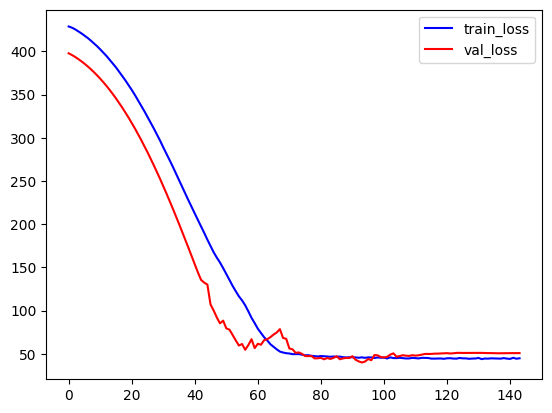

In [27]:
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

# Total dataset Evaluation and Plot results + Save results

In [28]:
# evaluation
model_stock.eval()
with torch.no_grad():
    pred_stock = model_stock(x_test_stock.to(device))
pred_stock = pred_stock.to('cpu').detach().numpy()
pred_stock_reshape = np.reshape(pred_stock,(-1,1))
print(pred_stock_reshape.shape)

(20, 1)


In [29]:
### Evaluate with error_ratio
print('Error Ratio :',error_ratio(pred_stock_reshape, y_test_SEQ))

### R-squared, p-value
# r_squared는 1에 가까울수록 모델이 좋은 것
# p_value는 0.05 보다 작으면 유의미한 것
# 두가지를 만족하지 못한 것은 과적합된 것
r_squared = sm.OLS(y_test_SEQ,sm.add_constant(pred_stock_reshape)).fit().rsquared
p_value = sm.OLS(y_test_SEQ,sm.add_constant(pred_stock_reshape)).fit().f_pvalue
print("R-squared:", r_squared)
print("p-value:", p_value)

Error Ratio : 0.6069752333778115
R-squared: 0.6386546183543369
p-value: 2.373318073552012e-05


In [30]:
### Save result
path = f'../../data/results/transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_stock.csv'

result_stock = pd.DataFrame(data={'true':np.reshape(y_test_SEQ,(-1)),
              'pred':np.reshape(pred_stock_reshape,(-1)),
              'error_ratio':((pred_stock_reshape-y_test_SEQ)/y_test_SEQ).iloc[:,0].values},
              index=y_test_SEQ.index)

result_stock.to_csv(path)

# result_stock = pd.read_csv(path,index_col=0) # set date column as index when reading the data

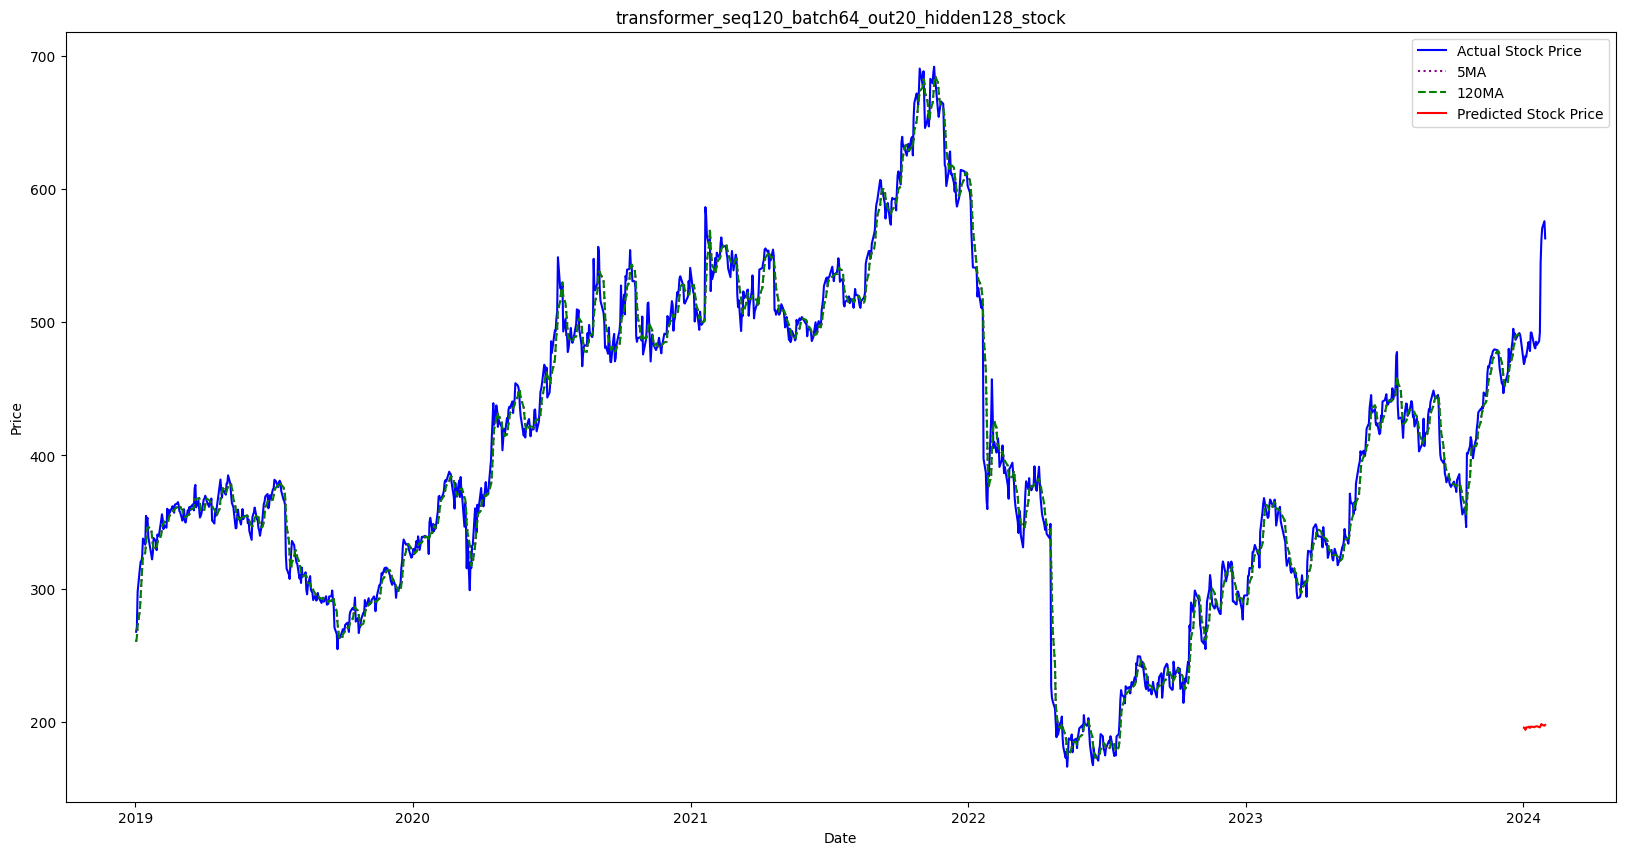

In [31]:
### Plot Result
actual_stock_price = stock_df[['Close','5MA','120MA']].reset_index().rename(columns={'Close':'true'})
actual_stock_price[['pred','error_ratio']] = 0
combined_df = pd.concat([actual_stock_price,
                        result_stock.copy().reset_index()],
                        axis=0)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.reset_index(drop=True)
combined_df

plt.figure(figsize=(20,10))
plt.plot(combined_df['Date'], combined_df['true'],
         color='blue',label='Actual Stock Price')
plt.plot(combined_df['Date'][:-OUTPUT_SIZE],combined_df['5MA'][:-OUTPUT_SIZE],
        color='purple',linestyle=':',label='5MA')
plt.plot(combined_df['Date'][:-OUTPUT_SIZE],combined_df['5MA'][:-OUTPUT_SIZE],
        color='green',linestyle='--',label='120MA')
plt.plot(combined_df['Date'][-OUTPUT_SIZE:],combined_df['pred'][-OUTPUT_SIZE:],color='red',
         label='Predicted Stock Price')
for i,row in combined_df.iterrows():
    if not np.isnan(row['error_ratio']):
        plt.annotate(f'{row["error_ratio"]*100:1f}%',(i,row['pred']),
                 textcoords='offset points',xytext=(0,10),ha='center')

plt.title(f'transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

fig_path = f'../../plots/results/transformer_seq{SEQUENCE_SIZE}_batch{BATCH_SIZE}_out{OUTPUT_SIZE}_hidden{HIDDEN_SIZE}_stock.png'
plt.savefig(fig_path,dpi=300)
plt.show()